# 03: Entangled Deep Dream

In [3]:
%pip install torch numpy matplotlib diffusers datasets tqdm transformers accelerate

Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import numpy as np

from diffusers import AutoencoderKL,  PNDMScheduler, UNet2DConditionModel, StableDiffusionPipeline
from datasets import load_dataset
from functools import lru_cache, cached_property
from dataclasses import dataclass
from tqdm import tqdm
import math

## Model setup

In [5]:
backend_name = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
backend_name

'mps'

In [6]:
dtype = torch.float32
if backend_name == "cuda:0":
    dtype = torch.float16

In [7]:
model_id = "sd-legacy/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=dtype)
pipe = pipe.to(backend_name)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


## Test data

In [8]:
dataset = load_dataset("timm/mini-imagenet", split="test")

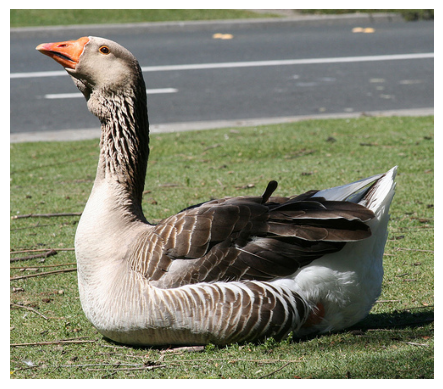

In [9]:
test_img = dataset[300]['image']
np_img = np.array(test_img)
plt.axis('off')
plt.imshow(np_img)

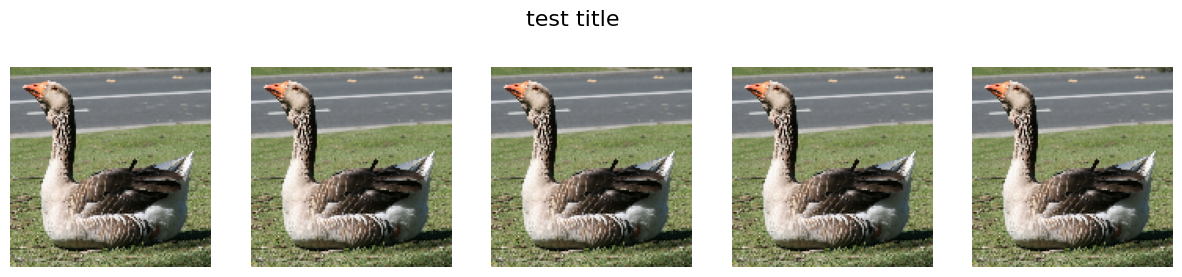

In [10]:
test_images = torch.tensor(np.array([np_img] * 5), device=pipe.device, dtype=dtype) # (N, H, W, C)

def to_chw(images: torch.Tensor) -> torch.Tensor:
    return images.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

def to_hwc(images: torch.Tensor) -> torch.Tensor:
    return images.permute(0, 2, 3, 1)  # (N, C, H, W) -> (N, H, W, C)

def normalize(tensor: torch.Tensor) -> torch.Tensor:
    max_val = tensor.max()
    min_val = tensor.min()

    if max_val == min_val:
        return torch.zeros_like(tensor)

    norm_0_1 = (tensor - min_val) / (max_val - min_val)

    return norm_0_1 * 2.0 - 1.0

def denormalize(tensor: torch.Tensor) -> torch.Tensor:
    max_val = tensor.max()
    min_val = tensor.min()

    if max_val == min_val:
        return torch.zeros_like(tensor)
    tensor = (tensor - min_val) / (max_val - min_val)

    return tensor * 255.0

test_images = to_chw(test_images)

test_images = torch.nn.functional.interpolate(test_images, size=(128, 128), mode='bilinear')

test_images = normalize(test_images)

def show_images(images: torch.Tensor, size=(15, 15), title=None, save_path=None):
    # Assuming denormalize and to_hwc are defined elsewhere in your code
    images = denormalize(images)

    plt.figure(figsize=size)

    if title is not None:
        plt.suptitle(title, fontsize=16, y=0.6)

    for i in range(images.shape[0]):
        img = to_hwc(images)[i].cpu().int().numpy()
        plt.subplot(1, images.shape[0], i + 1)
        plt.imshow(img)
        plt.axis('off')

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
        print(f"Figure saved to {save_path}")

    plt.show()

show_images(test_images, title="test title")

## Model wrapper

In [22]:
class UNetWrapper(nn.Module):
    def __init__(self, pipe: StableDiffusionPipeline, timestep: int, prompt: str = "", use_noise: bool = True):
        super().__init__()
        self.pipe = pipe
        self.unet: UNet2DConditionModel = pipe.unet
        self.scheduler: PNDMScheduler = pipe.scheduler
        self.device = pipe.device
        self.dtype = pipe.unet.dtype
        self.prompt = prompt
        self.timestep_tensor = torch.tensor([timestep], device=pipe.device).int()
        self.timestep = timestep
        self.use_noise = use_noise

    @lru_cache
    def embeddings(self, batch_size: int):
        _, negative_embeds = self.pipe.encode_prompt(
            prompt="",
            device=pipe.device,
            num_images_per_prompt=batch_size,
            do_classifier_free_guidance=True,
            negative_prompt=None
        ) # negative embeds are empty prompt embeddings (None)
        return negative_embeds


    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the UNet with the given timestep and prompt embeddings.
        :param z: Latent input tensor of shape (batch_size, channels, height, width)
        :return: Latent output tensor of shape (batch_size, channels, height, width)
        """
        z = z.to(self.device, dtype=self.dtype)

        batch_size = z.shape[0]
        embeddings = self.embeddings(batch_size)
        c = z.shape[1]
        h = z.shape[2]
        w = z.shape[3]
        if self.use_noise:
            noise = torch.randn((batch_size, c, h, w), device=pipe.device, dtype=pipe.dtype)
            z_noise = self.scheduler.add_noise(z, noise, self.timestep_tensor)

        return self.unet(
            sample=z_noise if self.use_noise else z,
            timestep=self.timestep,
            encoder_hidden_states=embeddings
        ).sample

In [12]:
vae: AutoencoderKL = pipe.vae

def encode_images(images: torch.Tensor) -> torch.Tensor:
    """
    Encode images into latent space using the VAE encoder.
    :param images: Input images tensor of shape (batch_size, channels, height, width)
    :return: Latent representation tensor of shape (batch_size, latent_channels, latent_height, latent_width)
    """
    with torch.no_grad():
        latent_dist = vae.encode(images).latent_dist
        latents = latent_dist.sample()
        latents = latents * vae.config.scaling_factor
    return latents

def decode_latents(latents: torch.Tensor) -> torch.Tensor:
    """
    Decode latent representations back into images using the VAE decoder.
    :param latents: Latent representation tensor of shape (batch_size, latent_channels, latent_height, latent_width)
    :return: Decoded images tensor of shape (batch_size, channels, height, width)
    """
    with torch.no_grad():
        latents = latents / vae.config.scaling_factor
        images = vae.decode(latents).sample
    return images

In [13]:
model_test = UNetWrapper(pipe, timestep=1).to(backend_name).eval()
print(test_images.shape)
latent = encode_images(test_images)
print(latent.shape)
latent_noise = model_test.forward(latent)
print(latent_noise.shape)
noise = decode_latents(latent_noise)
print(noise.shape)

torch.Size([5, 3, 128, 128])
torch.Size([5, 4, 16, 16])
torch.Size([5, 4, 16, 16])
torch.Size([5, 3, 128, 128])


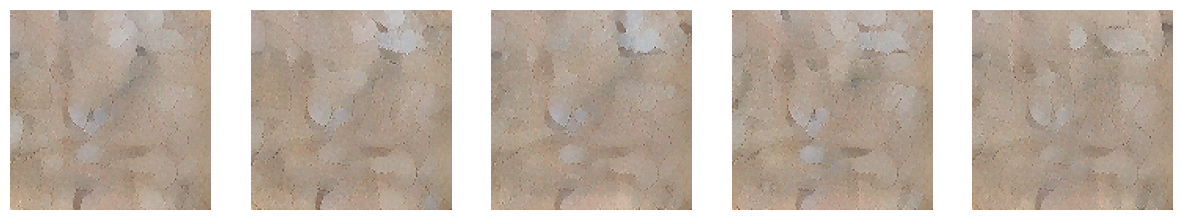

In [14]:
with torch.no_grad():
    show_images(noise)

## Deep Dream sanity check
First we will do a deep dream of a layer in the UNet without any additional noising and SAE

### Choosing a layer

In [16]:
module_names = []
for module in model_test.unet.named_modules():
    print(module[0])
    module_names.append(module[0])


conv_in
time_proj
time_embedding
time_embedding.linear_1
time_embedding.act
time_embedding.linear_2
down_blocks
down_blocks.0
down_blocks.0.attentions
down_blocks.0.attentions.0
down_blocks.0.attentions.0.norm
down_blocks.0.attentions.0.proj_in
down_blocks.0.attentions.0.transformer_blocks
down_blocks.0.attentions.0.transformer_blocks.0
down_blocks.0.attentions.0.transformer_blocks.0.norm1
down_blocks.0.attentions.0.transformer_blocks.0.attn1
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.1
down_blocks.0.attentions.0.transformer_blocks.0.norm2
down_blocks.0.attentions.0.transformer_blocks.0.attn2
down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_q
down_blocks.0.attenti

In [38]:
LAYER_NAME = "down_blocks.0.resnets.0.conv1"
CHANNEL = 5
LATENT_SIZE = 16
BATCH_SIZE = 5
TIMESTEP = 1

@dataclass
class E0Config:
    layer_name: str
    channel: int
    latent_size: int
    batch_size: int
    timestep: int

    @cached_property
    def layer_depth(self) -> float:
        """
        Returns the depth of the layer as a percentage of the total number of layers [0, 1].
        :return:
        """
        block = self.layer_name.split(".")[0]
        if block == "down_blocks":
            return 0.2
        elif block == "mid_blocks":
            return 0.6
        else:
            return 0.8


    @cached_property
    def steps(self) -> int:
        return math.floor(50 + 250 * self.layer_depth)

    @cached_property
    def lr(self) -> float:
        return 0.1 ** (self.layer_depth + 1)


def experiment_e0(config: E0Config, use_noise = True) -> torch.Tensor:
    model = UNetWrapper(pipe, timestep=config.timestep, use_noise=use_noise).to(backend_name).eval()

    latents = torch.randn(BATCH_SIZE, 4, config.latent_size, config.latent_size, device=model.device, dtype=dtype) * 0.01
    latents.requires_grad_(True)

    optimizer = torch.optim.Adam([latents], lr=config.lr)

    activations = {}
    def get_activation(name):
        def hook(model, input, output):
            # for attention layers
            if isinstance(output, tuple):
                activations[name] = output[0]
            else:
                activations[name] = output
        return hook

    target_layer = dict(model.unet.named_modules())[config.layer_name]
    hook_handle = target_layer.register_forward_hook(get_activation("target"))

    print(f"Optimizing Channel {config.channel} on {config.layer_name} at timestep {config.timestep} for {config.steps} steps with lr {config.lr}...")


    pbar = tqdm(range(config.steps))
    try:
        for i in pbar:
            optimizer.zero_grad()

            _ = model(latents)

            act = activations["target"]

            loss = -act[:, config.channel].mean()
            loss.backward()
            optimizer.step()

            pbar.set_description(f"Loss: {loss.item():.4f}")

    except KeyboardInterrupt:
        print("Optimization stopped by user.")
    except Exception as e:
        raise e
    finally:
        hook_handle.remove()
        print("Hook removed.")

    print("Decoding final result...")
    final_images = decode_latents(latents.detach())
    return final_images

E0Config(layer_name='down_blocks.0.resnets.0.conv1', channel=0, latent_size=16, batch_size=5, timestep=0)
Optimizing Channel 0 on down_blocks.0.resnets.0.conv1 at timestep 0 for 100 steps with lr 0.06309573444801933...


Loss: -1.2357:  52%|█████▏    | 52/100 [00:08<00:07,  6.30it/s]


Optimization stopped by user.
Hook removed.
Decoding final result...
Figure saved to ./results/down_blocks.0.resnets.0.conv1-ch0-t0-it100-lr0.06309573444801933.png


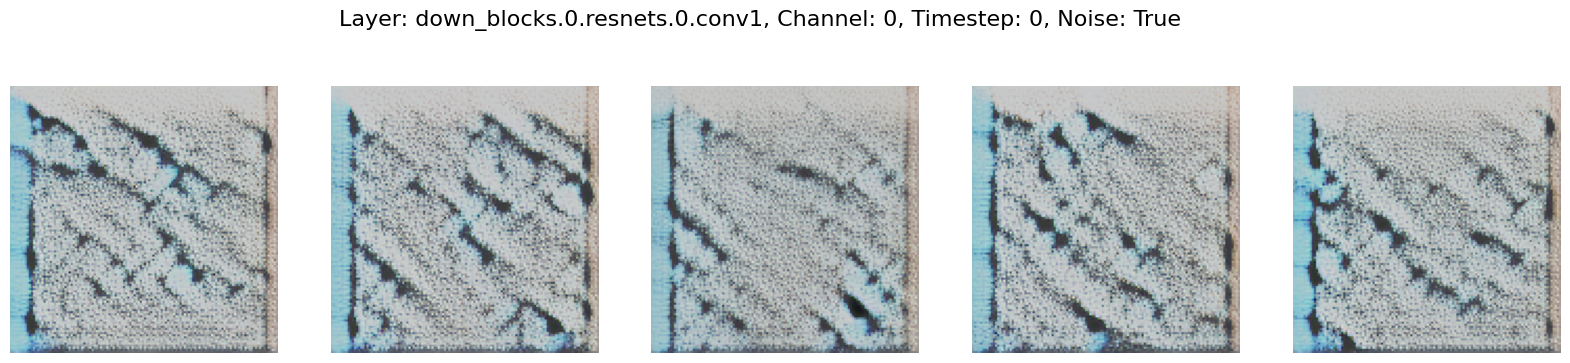

E0Config(layer_name='down_blocks.0.resnets.0.conv1', channel=7, latent_size=16, batch_size=5, timestep=0)
Optimizing Channel 7 on down_blocks.0.resnets.0.conv1 at timestep 0 for 100 steps with lr 0.06309573444801933...


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
configs = []

for l in ["down_blocks.0.resnets.0.conv1", "down_blocks.0.resnets.0.conv2",  "down_blocks.1.resnets.1.conv1", "down_blocks.1.resnets.0.conv1", "down_blocks.0.attentions.1.transformer_blocks.0.attn1"]:
    for t in [0, 50, 200, 400, 800, 999]:
        for c in [0, 7]:
            configs.append(E0Config(layer_name=l, channel=c, latent_size=16, batch_size=5, timestep=t))

for config in configs:
        print(config)
        final_image = experiment_e0(config)
        title = f"Layer: {config.layer_name}, Channel: {config.channel}, Timestep: {config.timestep}, Noise: True"
        path = f"./results/{config.layer_name}-ch{config.channel}-t{config.timestep}-it{config.steps}-lr{config.lr}.png"
        show_images(final_image, size=(20,20), title=title, save_path=path)

        # final_image = experiment_e0(config, use_noise=False)
        # title = f"Layer: {config.layer_name}, Channel: {config.channel}, Timestep: {config.timestep}, Noise: False"
        # path = f"./results/{config.layer_name}-ch{config.channel}-t{config.timestep}-it{config.steps}-lr{config.lr}-no-noise.png"
        # show_images(final_image, size=(20,20), title=title, save_path=path)

In [ ]:
import 